#### Model Checkpointing

In [1]:
%load_ext watermark
%watermark -v -p numpy,pandas,matplotlib,torch

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.14.0

numpy     : 1.24.3
pandas    : 2.0.2
matplotlib: 3.7.1
torch     : 2.0.1



In [2]:
!pip install lightning;


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python -m pip install --upgrade pip


In [4]:
import lightning as L
import torch
from lightning.pytorch.loggers import CSVLogger

from shared_utilities import CustomDataModule, LightningModel


In [5]:
class PyTorchMLP(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = torch.nn.Sequential(
            #1st hidden layer
            torch.nn.Linear(num_features, 100),
            torch.nn.ReLU(),
            #2nd hidden layer
            torch.nn.Linear(100, 50),
            torch.nn.ReLU(),
            #output layer
            torch.nn.Linear(50, num_classes)
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        logits = self.all_layers(x)
        return logits        
    

In [6]:
torch.manual_seed(123)

dm =  CustomDataModule()

pytorch_model = PyTorchMLP(num_features=100, num_classes=2)


### New: Model Checkpointing

In [11]:
from lightning.pytorch.callbacks import ModelCheckpoint

callbacks = [
    ModelCheckpoint(save_top_k=1, mode="max", monitor="val_acc", save_last=True)
]

In [12]:
lightning_model = LightningModel(model=pytorch_model, learning_rate=0.05)

trainer = L.Trainer(
    callbacks=callbacks,
    max_epochs=10,
    accelerator="cpu",
    devices="auto",
    logger=CSVLogger(save_dir="logs/", name="my_model_ckpts"),
    deterministic=True,
)

trainer.fit(model=lightning_model, datamodule=dm)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | PyTorchMLP         | 15.3 K
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 450/450 [00:02<00:00, 154.97it/s, v_num=0, val_loss=0.362, val_acc=0.862, train_acc=0.881]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 450/450 [00:02<00:00, 154.44it/s, v_num=0, val_loss=0.362, val_acc=0.862, train_acc=0.881]


#### Visualize checkpoints

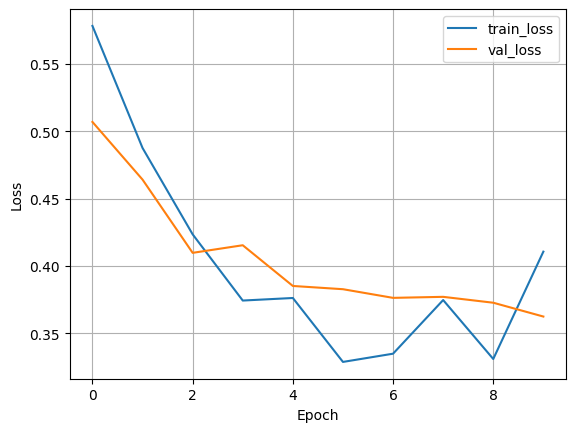

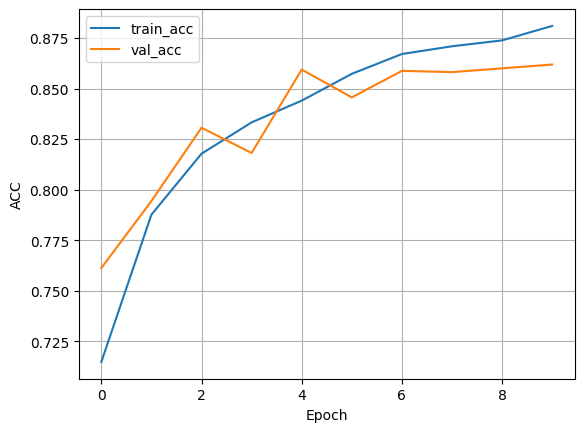

In [15]:
from shared_utilities import plot_csv_logger

plot_csv_logger(csv_path=f"{trainer.logger.log_dir}/metrics.csv")

### Best Checkpoint

In [16]:
trainer.test(model=lightning_model, datamodule=dm, ckpt_path="best")

Restoring states from the checkpoint path at logs/my_model_ckpts/version_0/checkpoints/epoch=9-step=4500.ckpt
Loaded model weights from the checkpoint at logs/my_model_ckpts/version_0/checkpoints/epoch=9-step=4500.ckpt


Testing DataLoader 0: 100%|██████████| 125/125 [00:00<00:00, 204.16it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8644999861717224     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8644999861717224}]

In [17]:
trainer.test(model=lightning_model, datamodule=dm, ckpt_path="last")

Restoring states from the checkpoint path at /workspaces/DeepLearning/logs/my_model_ckpts/version_0/checkpoints/last.ckpt
Loaded model weights from the checkpoint at /workspaces/DeepLearning/logs/my_model_ckpts/version_0/checkpoints/last.ckpt


Testing DataLoader 0: 100%|██████████| 125/125 [00:00<00:00, 322.47it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8644999861717224     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8644999861717224}]

In [18]:
path = trainer.checkpoint_callback.best_model_path

print(path)

logs/my_model_ckpts/version_0/checkpoints/epoch=9-step=4500.ckpt


In [19]:
lightning_model = LightningModel.load_from_checkpoint(
    path, learning_rate=0.1, model=pytorch_model
)
lightning_model.eval();